# An example on covariate and phenotype generation

This example shows how to generate covariates and phenotypes out of these covariates. In the process generation, covariates such as age, sex, diagnosis are considered to be independent. Estimated total intracranial volume (eTIV or ICV) is known to be dependent on age and sex. However, we won't consider its influence on diagnosis.

Data sample distribution can be iid (independent and identically distributed), mildly dependent, or strongly dependent (non-IID).

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from syncombat.covariates.generation import CovariateGenerator

In [20]:
cov_generator = CovariateGenerator(
    n_samples=500,
    n_sites=4,
    n_dx_groups=3,
    sex_non_iidness='low',
    age_non_iidness='high',
    site_non_iidness='low',
    diagnosis_non_iidness='low'
)
covs = cov_generator.dataframe
covs.head()

,Age,Sex,eTIV,Site,DX
0,89.807892,Male,1511.886230,Site 1,DX 2
1,83.518555,Male,1511.088989,Site 0,DX 2
2,76.991287,Female,1400.269165,Site 0,DX 1
3,40.049145,Female,1399.697510,Site 2,DX 0
4,95.266174,Male,1526.255493,Site 1,DX 0


In [21]:
cov_generator.design_matrix.head()

,"C(Sex, Treatment(reference='Female'))[Male]","C(Sex, Treatment(reference='Female'))[Female]",C(DX)[T.DX 1],C(DX)[T.DX 2],standardize(Age)
0,1.0,0.0,0.0,1.0,0.496130
1,1.0,0.0,0.0,1.0,0.255428
2,0.0,1.0,1.0,0.0,0.005619
3,0.0,1.0,0.0,0.0,-1.408211
4,1.0,0.0,0.0,0.0,0.705026


Non-IIDness can be set to `low`, `medium`, or `high`. The higher the non-IIDness, the more different the covariate distributions are across sites. The following figure shows the distribution of age across sites for different non-IIDness levels.

<Figure size 640x480 with 0 Axes>

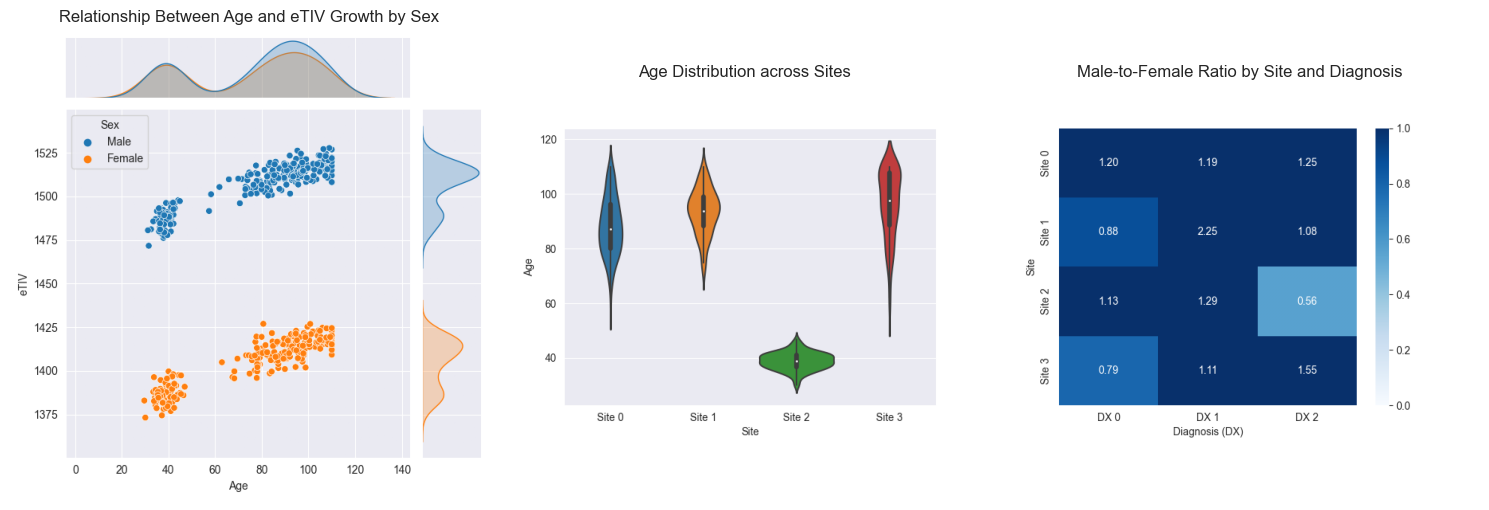

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import tempfile


def visualize_population(covs):
    # Create joint distribution plot of Age and Site
    plt.figure()
    g1 = sns.jointplot(data=covs, x='Age', y='eTIV', hue='Sex', kind='scatter')
    # g1.fig.suptitle("Relationship Between Age and eTIV Growth by Sex (centralized)", y=1.05)

    # Create violin plot of eTIV across different sites
    plt.figure()
    g2 = sns.violinplot(data=covs, x='Site', y='Age')
    # g2.set_title("Age Distribution across Sites", y=1.05)

    # Calculate the male-to-female ratio for each combination of site and diagnosis
    # Create a heatmap of the male-to-female ratio
    pivot_table = covs.pivot_table(
        index='Site',
        columns='DX',
        values='Sex',
        aggfunc=lambda x: (x == 'Male').sum() / (x == 'Female').sum()
    )
    plt.figure()
    g3 = sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt=".2f", vmin=0, vmax=1)
    g3.set_xlabel('Diagnosis (DX)')
    g3.set_ylabel('Site')
    # g3.set_title('Male-to-Female Ratio by Site and Diagnosis', y=1.05)

    # Save the FacetGrid plots as individual figures
    extension = '.png'
    with tempfile.NamedTemporaryFile(suffix=extension) as file1, \
            tempfile.NamedTemporaryFile(suffix=extension) as file2, \
            tempfile.NamedTemporaryFile(suffix=extension) as file3:
        g1.savefig(file1.name)
        g2.figure.savefig(file2.name)
        g3.figure.savefig(file3.name)

        plt.cla()
        plt.close('all')
        plt.clf()

        # Create the figure and display the plots side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Load the saved figures using plt.imread()
        image1 = plt.imread(file1.name, format=extension)
        image2 = plt.imread(file2.name, format=extension)
        image3 = plt.imread(file3.name, format=extension)

        # Display the images in the subplots
        axes[0].imshow(image1)
        axes[0].set_title("Relationship Between Age and eTIV Growth by Sex")
        axes[0].axis('off')

        axes[1].imshow(image2)
        axes[1].set_title("Age Distribution across Sites")
        axes[1].axis('off')

        axes[2].imshow(image3)
        axes[2].set_title("Male-to-Female Ratio by Site and Diagnosis")
        axes[2].axis('off')

        # Adjust the spacing between subplots
        plt.tight_layout()

        # Return the figure
        return fig


fig = visualize_population(covs)
plt.show()

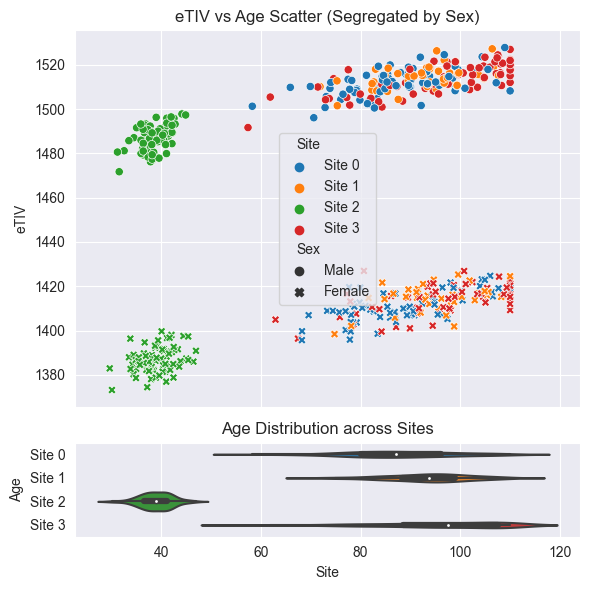

In [23]:
# Create the scatter subplot segregated by sex
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex='col', gridspec_kw={'height_ratios': [4, 1]})

sns.scatterplot(data=covs, x='Age', y='eTIV', hue='Site', style='Sex', ax=axes[0])
axes[0].set_xlabel('Age')
axes[0].set_ylabel('eTIV')
axes[0].set_title('eTIV vs Age Scatter (Segregated by Sex)')

# Create the violin plot of age and site
sns.violinplot(data=covs, y='Site', x='Age', ax=axes[1])
axes[1].set_xlabel('Site')
axes[1].set_ylabel('Age')
axes[1].set_title('Age Distribution across Sites')

plt.tight_layout()
plt.show()

In [24]:
from syncombat.phenotypes.models import LinearPhenotypeModel

pheno_model = LinearPhenotypeModel(tensor_design_matrix=cov_generator.tensor_design_matrix, n_phenotypes=4)

Let's create the whole synthetic dataset.

In [25]:
df = pheno_model.dataframe.join(cov_generator.dataframe)
df.head()

,Phenotype_0,Phenotype_1,Phenotype_2,Phenotype_3,Age,Sex,eTIV,Site,DX
0,0.704114,0.321707,0.556269,-0.215364,89.807892,Male,1511.886230,Site 1,DX 2
1,0.727699,0.400679,0.504363,-0.242802,83.518555,Male,1511.088989,Site 0,DX 2
2,0.265870,0.043069,0.415317,0.411493,76.991287,Female,1400.269165,Site 0,DX 1
3,0.509176,0.244290,-0.219968,0.184223,40.049145,Female,1399.697510,Site 2,DX 0
4,0.272829,-0.141068,0.540749,0.017226,95.266174,Male,1526.255493,Site 1,DX 0


Now let's visualize the relationship between the covariates and the phenotypes.

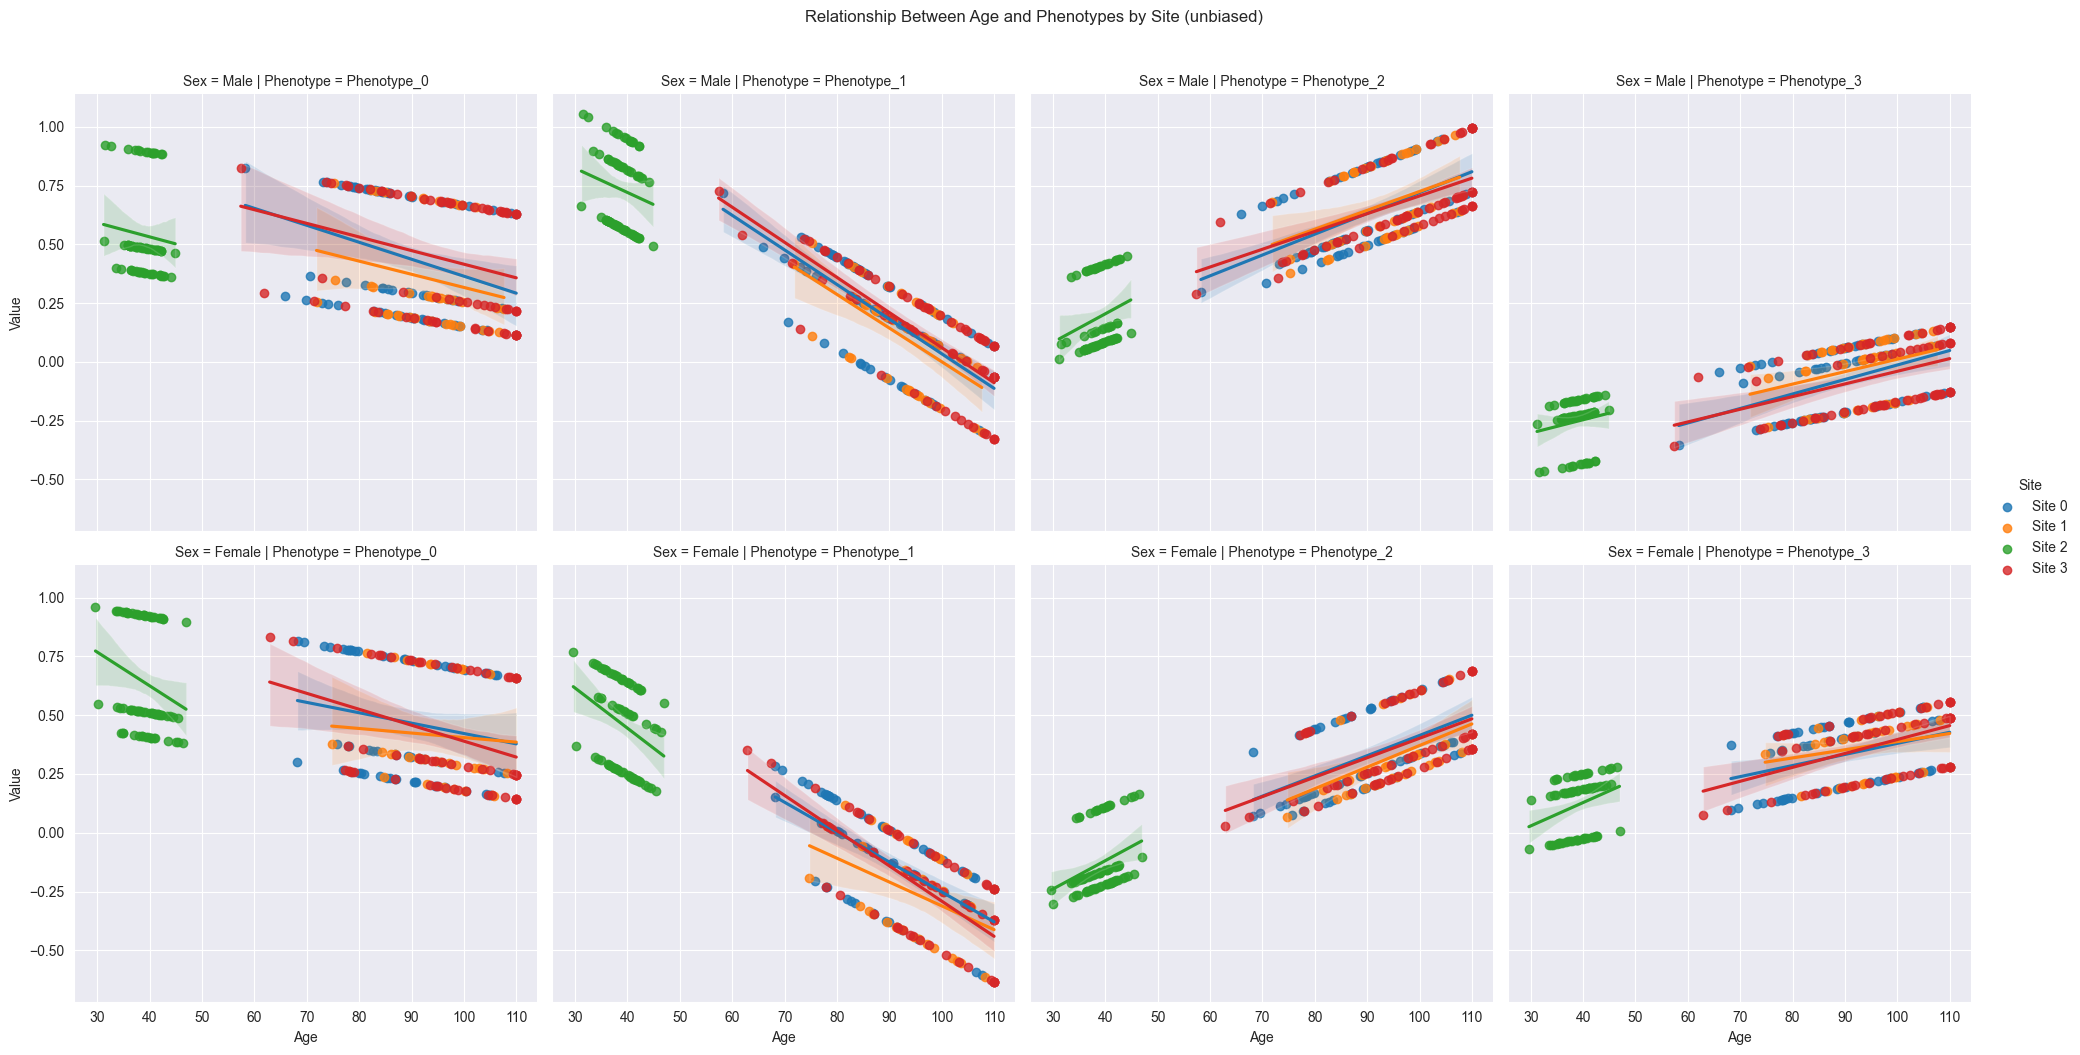

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Let's melt for visualization keeping the covariates as id vars
df_melt = df.melt(id_vars=covs.columns, value_vars=pheno_model.pheno_names, var_name='Phenotype', value_name='Value')

# And now let's visualize the relationship between the covariates and the phenotypes
g = sns.lmplot(data=df_melt, x='Age', y='Value', hue='Site', col='Phenotype', row='Sex')
g.fig.suptitle("Relationship Between Age and Phenotypes by Site (unbiased)", y=1.05)
plt.show()

# g = sns.relplot(data=df_melt, x='eTIV', y='Value', hue='Site', col='Phenotype', col_wrap=4, kind='scatter')


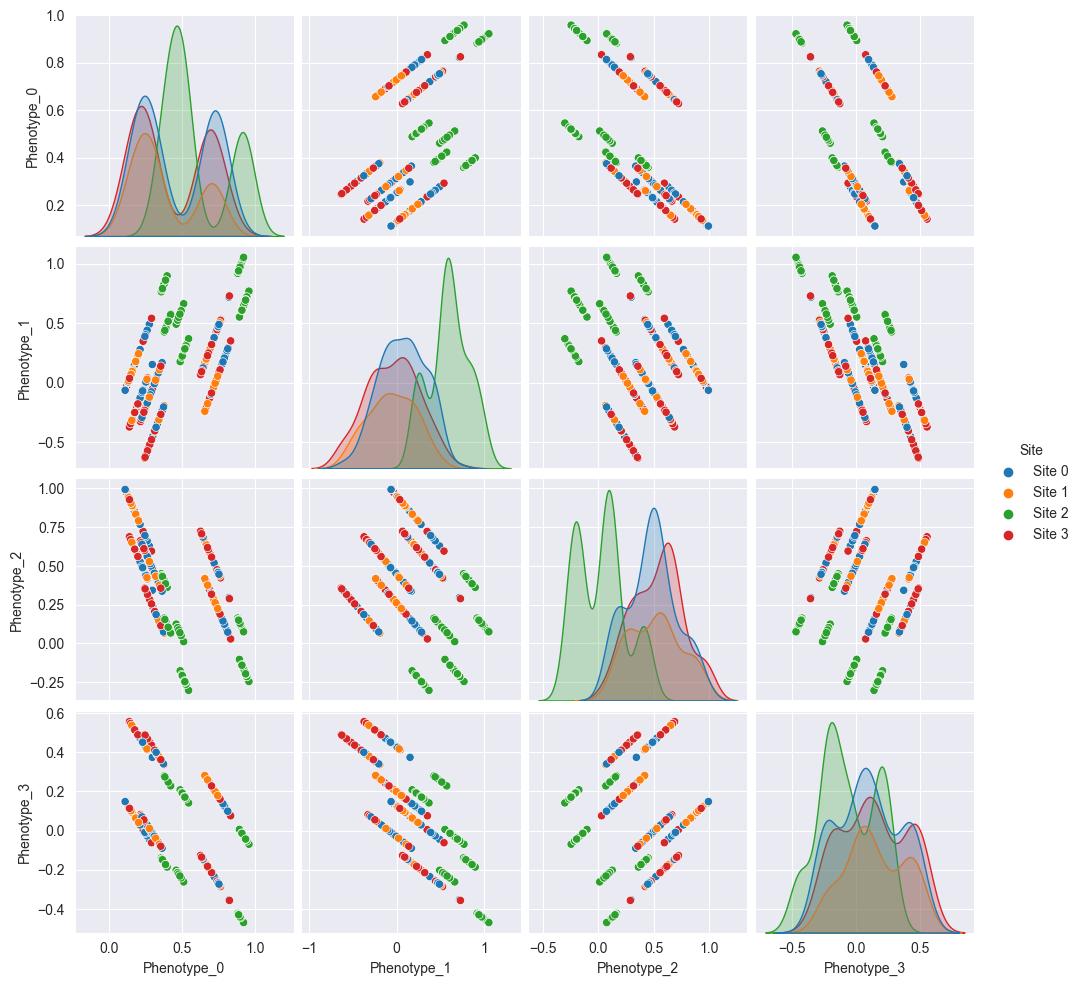

In [27]:
sns.pairplot(df, hue='Site', vars=pheno_model.pheno_names)